# Search using centroids and clustering

The goal of this tutorial is to demonstrate a more flexible method for cell search using centroids. Much of the early steps will be identical to individual cell search tutorial and thus the explanations for those steps will be reduced for the sake of brevity. We will again use the [Adams et al. 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data.

An important thing to note is that the cells input into the query are what determine the query results. The average of a scattered collection of cells will not bring meaningful results. There are some built-in quality controls stats you can use to evaluate the centroid quality and we will demonstrate them in this tutorial.

**There will be three analyses shown for querying cells:**

 1. Perform cell search on a regulatory T cell centroid from a tight cluster.
 2. Perform cell search on a T cell centroid from a less tight cluster.
 3. Perform cell search on a macrophage centroid from a broad cluster.

In [1]:
# Environment settings
import scanpy as sc
from matplotlib import pyplot as plt

sc.set_figure_params(dpi=100)

import warnings

warnings.filterwarnings("ignore")

## 1. Prepare for SCimilarity: Import and normalize data

In [2]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellQuery

In [3]:
## TODO
## RESTRUCTURE THE MODEL PATHS FOR DOWNLOAD FILES

# If the models haven't been downloaded please uncomment and run the two command below
#!curl -L -o /models/query_model_v1.1.tar.gz \
#https://zenodo.org/records/10685499/files/model_v1.1.tar.gz?download=1
#!tar -xzvf /models/query_model_v1.1.tar.gz

In [4]:
# Instantiate the CellQuery object
# Set model_path to the location of the uncompressed model
model_path = "/models/model_v1.1"
cq = CellQuery(model_path)

### Load scRNA-seq data

In [5]:
# To Download the demo data to the data/ directory uncomment and run the command below
#! curl -L -o "/data/GSE136831_subsample.h5ad" \
#https://zenodo.org/record/8242083/files/GSE136831_subsample.h5ad?download=1

In [6]:
# Load and preprocess the tutorial data.
# Set data_path to the location of the tutorial dataset
data_path = "/data/GSE136831_subsample.h5ad"
adams = sc.read(data_path)
adams = align_dataset(adams, cq.gene_order)
adams = lognorm_counts(adams)

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [7]:
adams.obsm["X_scimilarity"] = cq.get_embeddings(adams.X)

In [8]:
sc.pp.neighbors(adams, use_rep="X_scimilarity")
sc.tl.umap(adams)

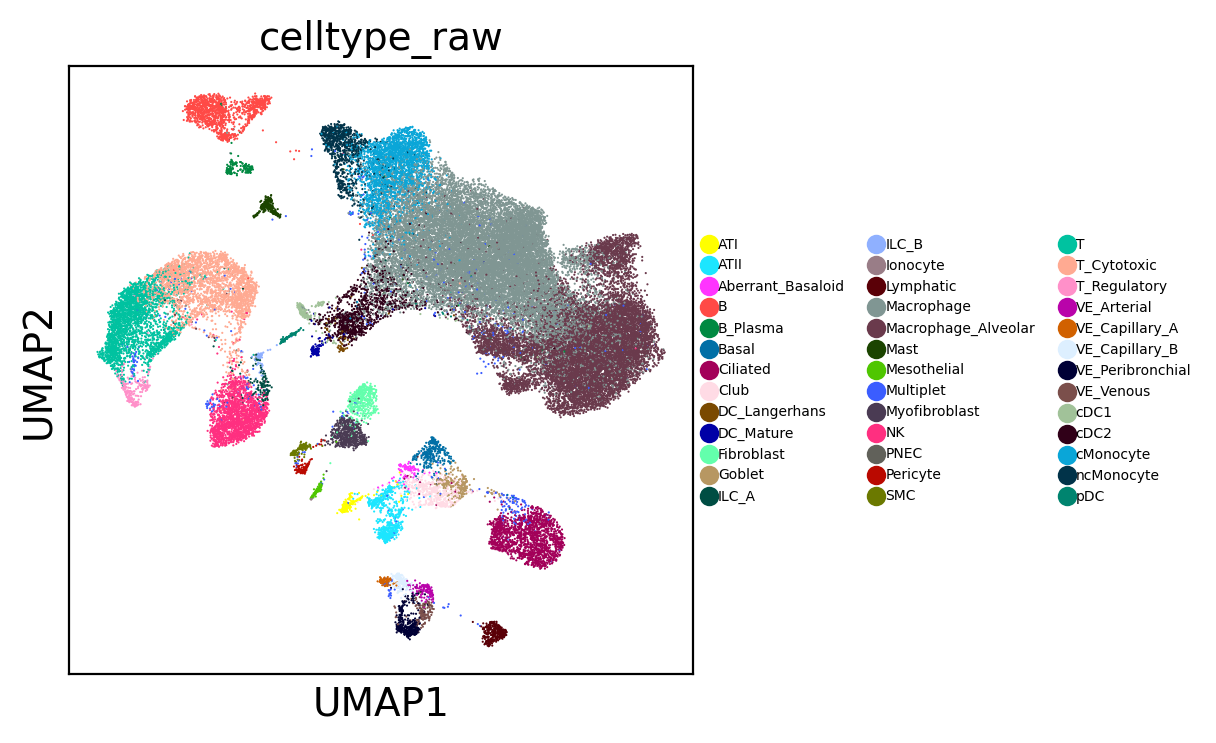

In [9]:
sc.pl.umap(adams, color="celltype_raw", legend_fontsize=5)

## 3. Identify query cell states

The more coherent and specific the query cell population is, the more interesting the results typically are. Cell states/subtypes are usually more interesting.

In this example, we use cell type information to identify query cells though we can also use clusters.

In [10]:
# Select Tregs
cells_used_in_query = adams.obs["celltype_raw"] == "T_Regulatory"
adams.obs["treg_query"] = cells_used_in_query.astype(int)

In [11]:
# Select non-specific T cells
cells_used_in_query = adams.obs["celltype_raw"] == "T"
adams.obs["t_query"] = cells_used_in_query.astype(int)

In [12]:
# Select broad macrophage population
cells_used_in_query = adams.obs["celltype_raw"] == "Macrophage"
adams.obs["macrophage_query"] = cells_used_in_query.astype(int)

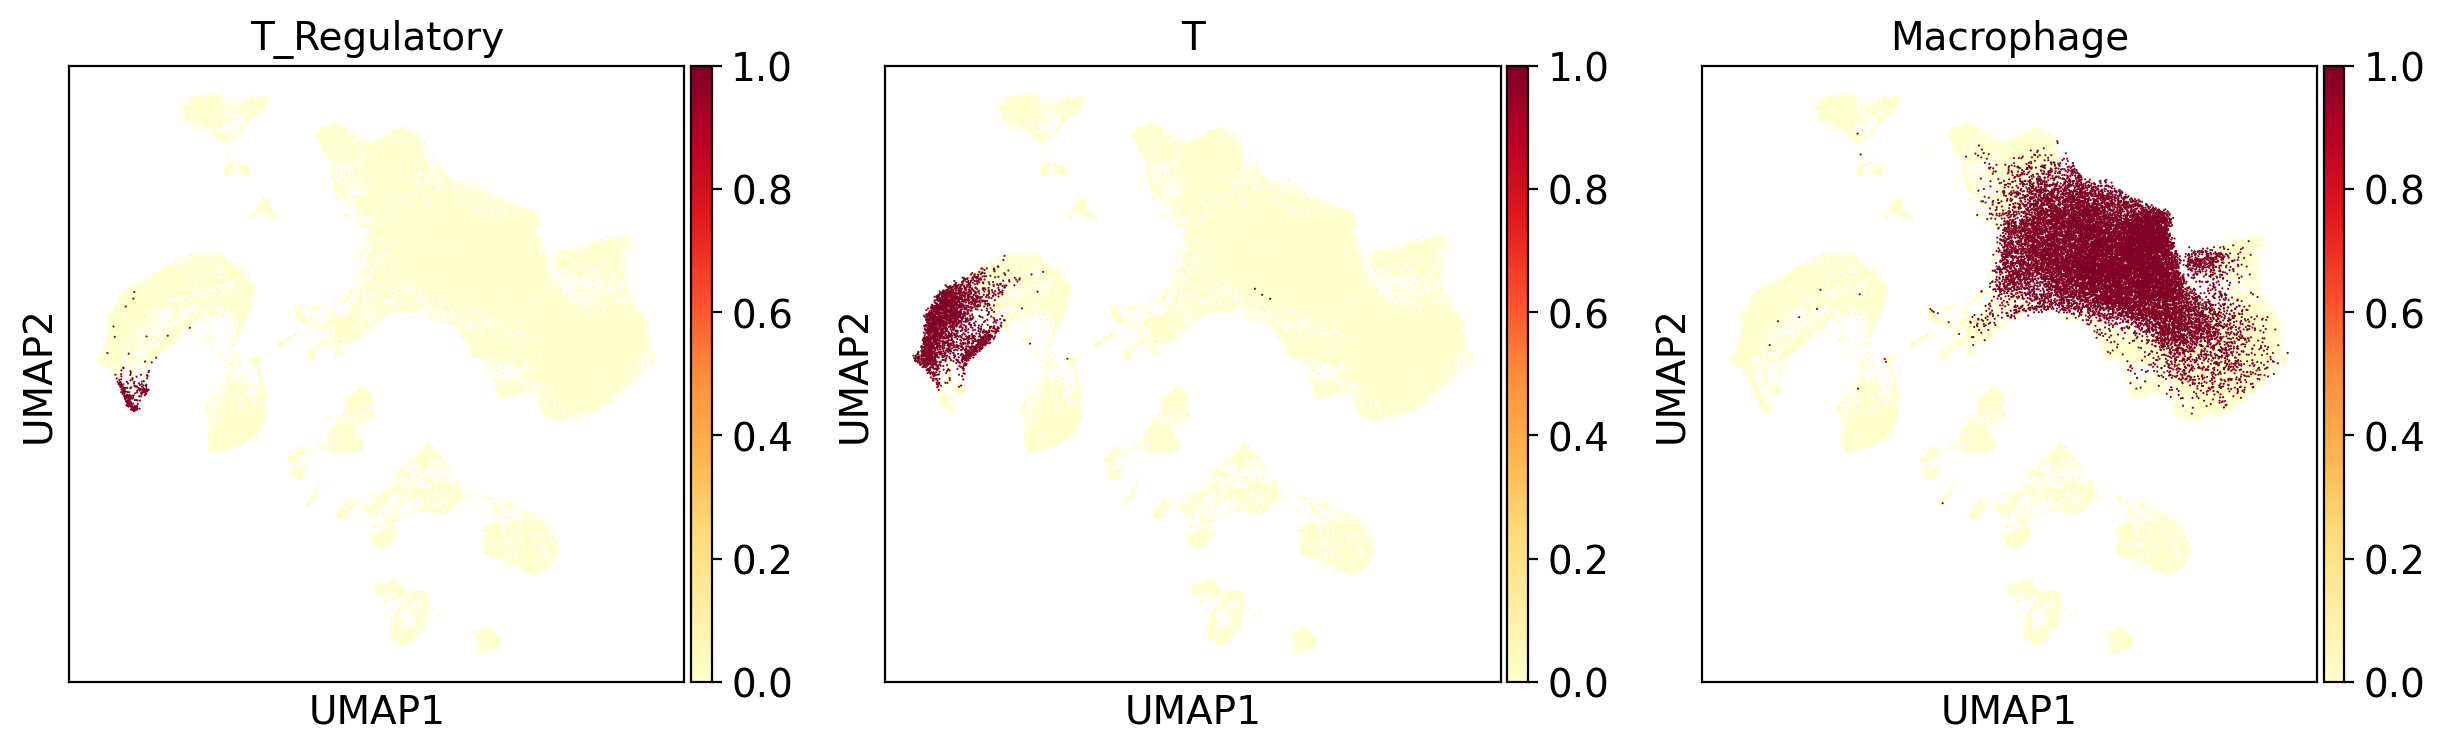

In [13]:
sc.pl.umap(
    adams,
    color=["treg_query", "t_query", "macrophage_query"],
    title=["T_Regulatory", "T", "Macrophage"],
    cmap="YlOrRd",
)

## 4. Perform cell search on a centroid
The centroid search method provides a QC output with which you can evaluate the quality of the centroid and search results.

Quality control statistics:
  - query_stability: consistency of query results between the centroid and cells that comprise the centroid.

In [14]:
# Treg query
centroid_embedding, nn_idxs, nn_dists, treg_metadata, qc_stats = cq.search_centroid(
    adams, "treg_query"
)
print(qc_stats)

{'centroid_stability': 0.6639917723104393, 'query_stability': 50.2}


In [15]:
# Non-specific T cell query
centroid_embedding, nn_idxs, nn_dists, t_metadata, qc_stats = cq.search_centroid(
    adams, "t_query"
)
print(qc_stats)

{'centroid_stability': 0.7111081724381315, 'query_stability': 51.6}


In [16]:
# Broad macrophage query
centroid_embedding, nn_idxs, nn_dists, macrophage_metadata, qc_stats = (
    cq.search_centroid(adams, "macrophage_query")
)
print(qc_stats)

{'centroid_stability': 0.52794741694642, 'query_stability': 18.4}


In [17]:
def calculate_disease_proportions(metadata):
    study_proportions = metadata.disease.value_counts()
    return 100 * study_proportions / study_proportions.sum()


def plot_proportions(df, title=None):
    ax = df.plot(
        kind="barh", xlabel="percent of cells", title=title, grid=False, figsize=(8, 5)
    )
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xticklabels([f"{int(tick)}%" for tick in ax.get_xticks()])
    plt.tight_layout()

### Exclude self-referencing results
Naturally, queries searching for similar cells will highlight cells from the same study. To get a clearer view of the results, we often exclude self-referencing hits.

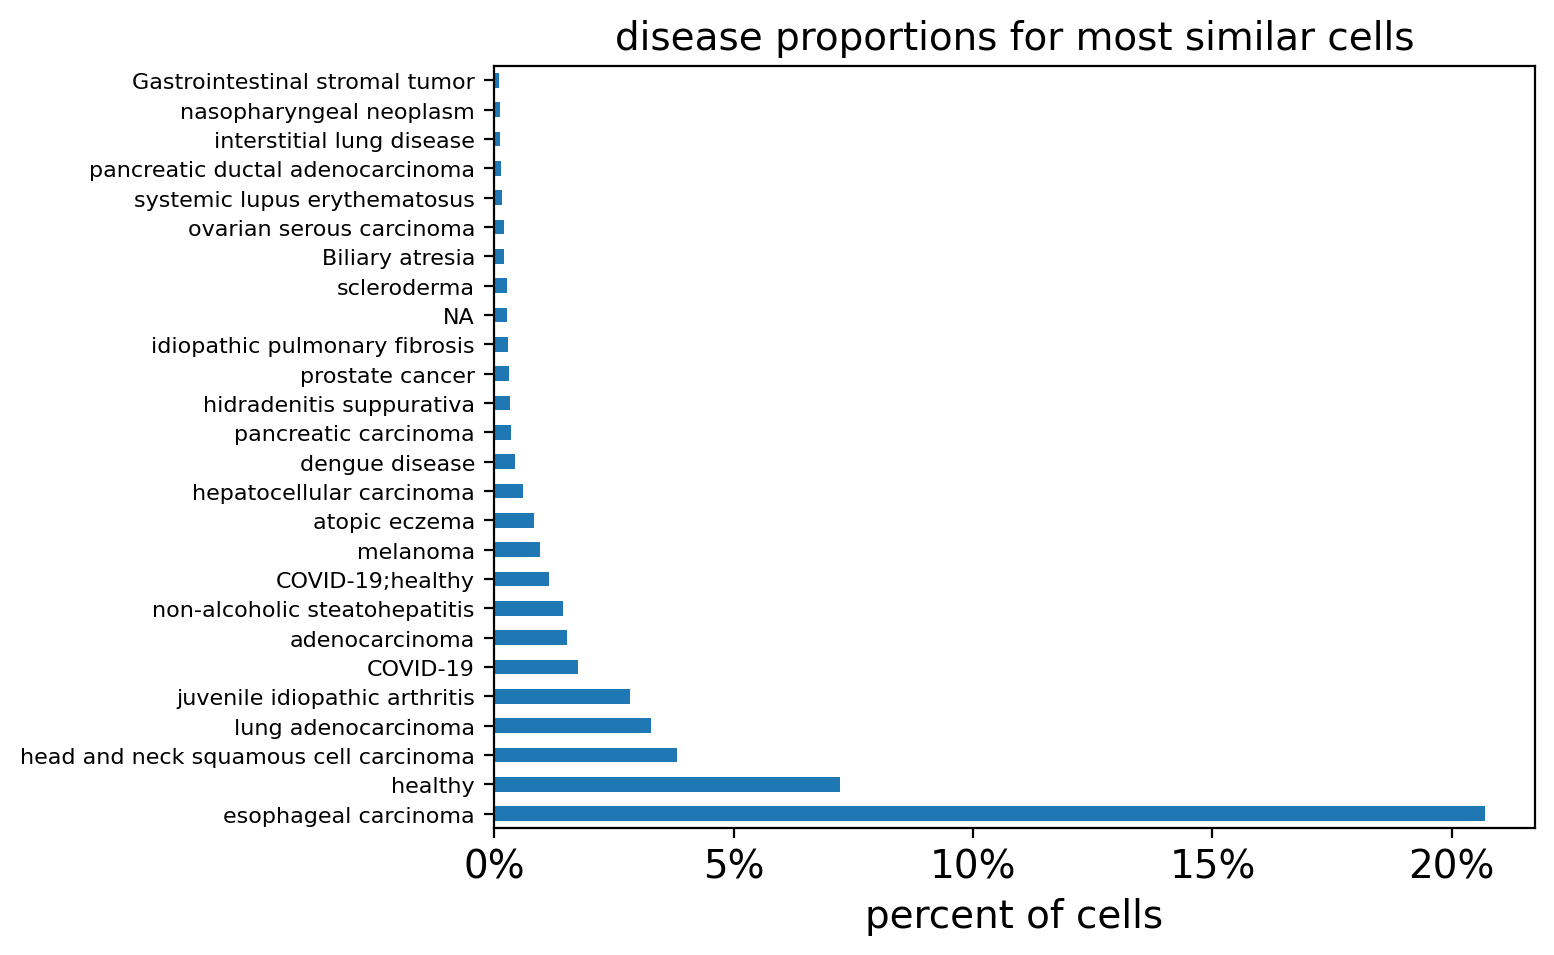

In [18]:
# Plot Treg results
query_study = "DS000011735"
filtered_result_metadata = treg_metadata[treg_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

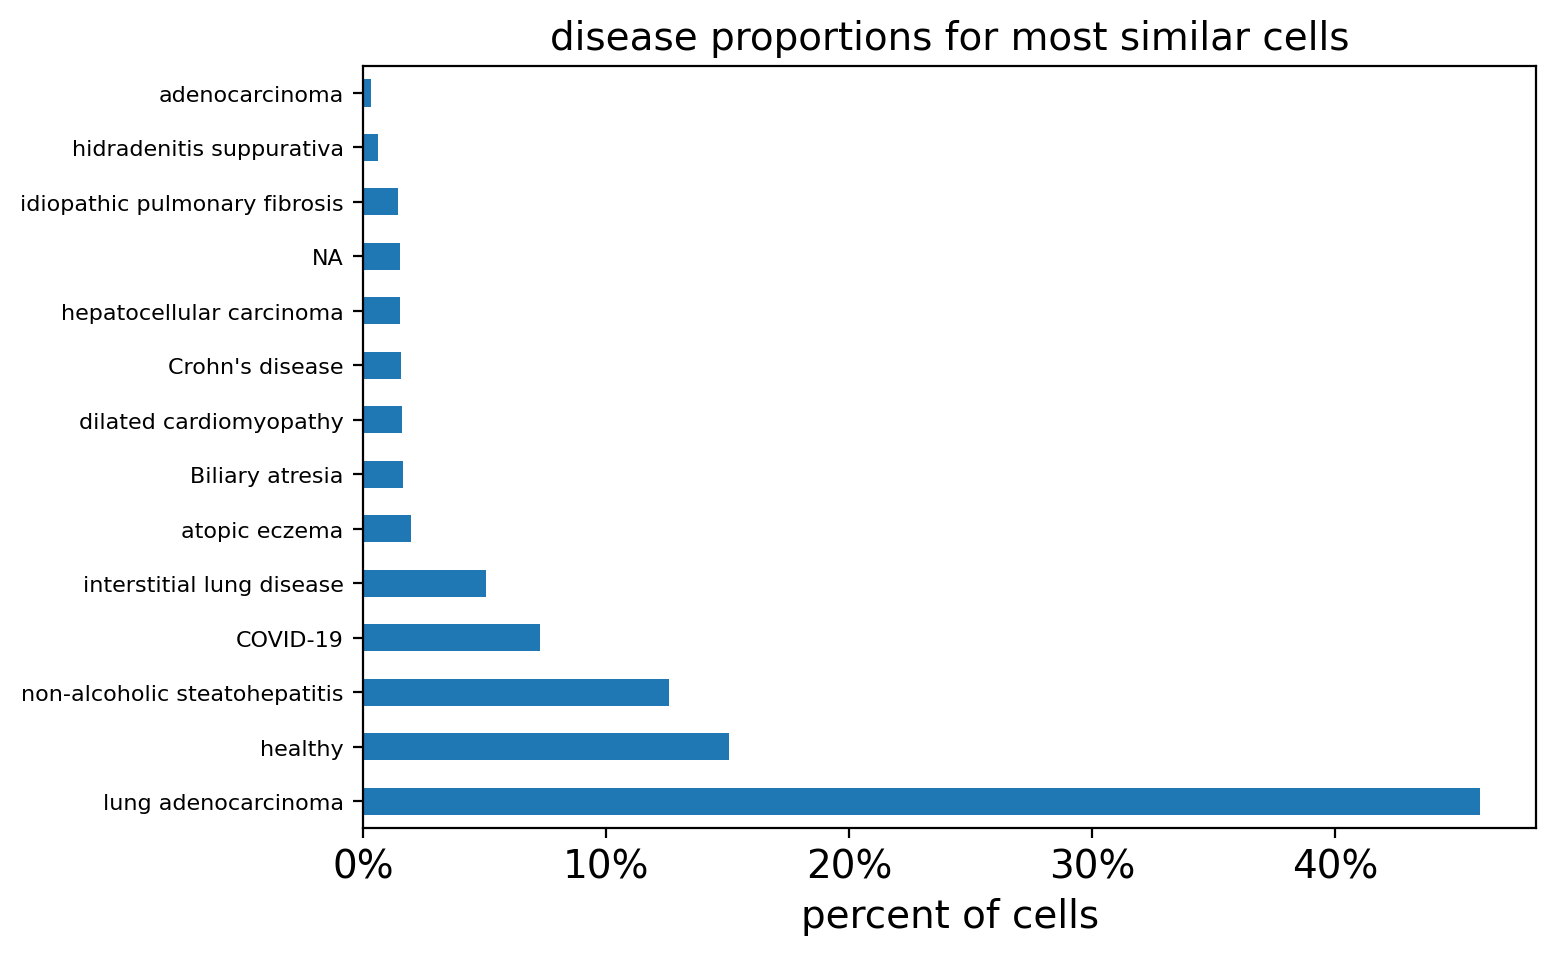

In [19]:
# Plot non-specific T cell results
query_study = "DS000011735"
filtered_result_metadata = t_metadata[t_metadata.study != query_study]
query_disease_frequencies = calculate_disease_proportions(filtered_result_metadata)
query_disease_frequencies = query_disease_frequencies[query_disease_frequencies>0.2]
plot_proportions(
    query_disease_frequencies, title="disease proportions for most similar cells"
)

In [20]:
# Plot broad macrophage results
query_study = "DS000011735"
filtered_result_metadata = macrophage_metadata[macrophage_metadata.study != query_study]
display(filtered_result_metadata)

,index,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,...,ESC-derived,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label,embedding_idx,query_nn_dist
3634,9104948,GSE128169,GSM3666106,macrophage,0.282966,4395.0,27645.0,1616.0,5.845542,0.013446,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.016505
4532,9102794,GSE128169,GSM3666106,macrophage,0.377627,5033.0,35058.0,1522.0,4.341377,0.014207,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.017116
6283,9104956,GSE128169,GSM3666106,macrophage,0.378897,4719.0,33088.0,1259.0,3.805005,0.012831,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.018143
7025,9102397,GSE128169,GSM3666106,macrophage,-0.005401,2529.0,8880.0,542.0,6.103603,0.012387,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.018517
7521,9100750,GSE128169,GSM3666105,macrophage,-0.146861,3924.0,19494.0,1051.0,5.391403,0.008712,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.018750
7751,9098242,GSE128169,GSM3666105,macrophage,-0.175670,2956.0,11384.0,526.0,4.620520,0.009469,...,False,False,lung,NA,interstitial lung disease,NA,NA,NA,0,0.018855
8603,2056851,GSE128033,GSM3660644,alveolar macrophage,0.034618,3427.0,14949.0,1532.0,10.248178,0.017707,...,False,False,lung,NA,healthy,SPP1/MERTK,NA,NA,0,0.019239
8604,9063517,GSE128169,GSM3666096,alveolar macrophage,0.034618,3427.0,14949.0,1532.0,10.248178,0.017707,...,False,False,lung,NA,healthy,NA,NA,NA,0,0.019239
8689,2054857,GSE128033,GSM3660644,macrophage,0.099563,3174.0,12319.0,1394.0,11.315854,0.014965,...,False,False,lung,NA,healthy,SPP1/MERTK,NA,NA,0,0.019276
8690,9061523,GSE128169,GSM3666096,macrophage,0.099563,3174.0,12319.0,1394.0,11.315854,0.014965,...,False,False,lung,NA,healthy,NA,NA,NA,0,0.019276


The results for the poor query centroid is empty after filtering out the query study because it could only match cells from the query study.

## Conclusion
This notebook outlines the basics of how to take a dataset, construct a centroid from a cluster, and perform a cell search across our precomputed reference of 23.4M cells and summarize the results. You can use this as a template to expore cell states in other datasets you are interested in. 

Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
  - Data generated from the 10x Genomics Chromium platform (models are trained using this data only).
  - Human scRNA-seq data.
  - Counts normalized with SCimilarity functions or using the same process. Different normalizations will have poor results.